# Permutation test for paired data

Now let’s turn to the permutation test itself, starting with the case of paired data. These are situations where we want to compare two conditions or groups, and each datapoint in one group has a corresponding partner in the other.

Paired data arise in several common experimental designs, including:

* Matched pairs, such as siblings, twins, or participant pairs matched on age, gender, or some other characteristic.
* Repeated measures, where the same individual is measured under two different conditions — for example:
    * before and after an intervention
    * on-drug and off-drug
    * reaction times across different conditions measured within an individual

In these designs, each value in one group has a natural counterpart in the other, which allows us to look at the within-pair differences rather than comparing two independent groups.


### Set up Python libraries

As usual, run the code cell below to import the relevant Python libraries

In [49]:
# Set-up Python libraries - you need to run this but you don't need to change it
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns
sns.set_theme(style='white')
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Toy example

*[A toy example is an example with a very small dataset, just to show how it works]*

#### Question & Design

Suppose we suspect that men own more socks than women.


We decide to use a  **matched pairs design**, comparing sock ownership between husbands and wives. This helps control for lifestyle factors, such as household size, wardrobe space, and holiday habits, which are typically shared within a couple and could influence how many pairs of socks a person owns. In other words, by matching these couples, we reduce these confounding influences and focus on the sex difference within each pair.

#### Hypotheses

We can state our hypotheses as follows:

$\mathcal{H_o}:$ The mean sex difference in socks owned is zero. 
* on average husbands and wives own the same number of socks.

$\mathcal{H_a}:$ The mean sex difference *(husband-wife)* is greater than zero
* on average husbands own more socks than their wives


#### Data

We obtain sock counts from an informal sample of 14 couples:

In [50]:
socks = pd.read_csv('https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook_2024/main/data/socks.csv')
socks

Husband  Wife
0        10    12
1        17    13
2        48    20
3        28    25
4        23    18
5        16    14
6        18    13
7        34    26
8        27    22
9        22    14
10       12    10
11       13    17
12       22    21
13       15    16

### Let's plot those data. 

When you are trying to interpret a potential statistical difference, it’s usually best to start by plotting the data. A clear visualisation often reveals patterns, or the lack of them, long before any formal statistical test is run.

For paired data a **scatter plot** (perhaps with a *reference line*) is often a good choice (see the plot on the left). However, for a dataset this small, I prefer the style of plot shown on the right (*a bar plot with individual data lines for each couple*).

* *You won’t be required to produce this type of plot in the course, but if you’re curious, you can find instructions in Section 2.5 of this website.*


**Why do I prefer the plot on the right?**

In this analysis, we’re interested in whether husbands have more socks than their wives. The plot on the right makes this visually obvious, because you can simply check whether each connecting line slopes upward (husband has more) or downward (wife has more). However,  if we had hundreds or thousands of couples, this kind of paired-line plot would become too crowded to interpret. In larger datasets, a scatter plot or a histogram of paired differences is usually a better choice.

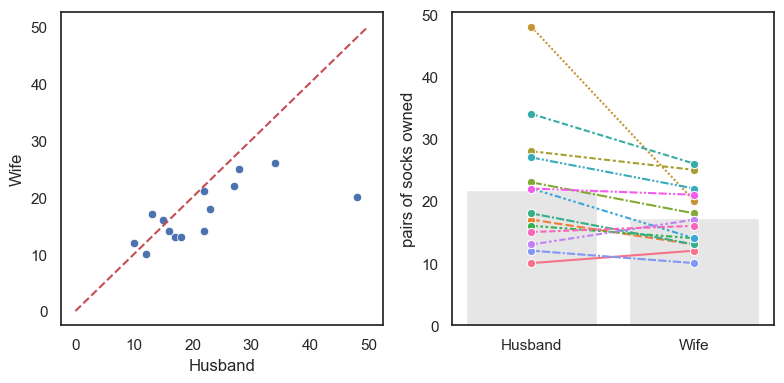

In [51]:
# Plotting code - don't get sidetracked by this, it's not that important
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.scatterplot(data=socks, x='Husband', y='Wife')
plt.plot([0,50],[0,50],'r--') # add the line x=y for comparison


plt.subplot(1,2,2)
sns.barplot(data=socks, errorbar=None, color=[0.9,0.9,0.9])
sns.lineplot(data=socks.T, legend=False, marker='o') # ci=None switches off errorbars
plt.ylabel('pairs of socks owned')

plt.tight_layout()
plt.show()

**Things to note:** 
* In most couples (11/14) the husband owns more socks that the wife
* There is one couple in which the husband has an extreme number of socks.

#### Test statistic

A test statistic is a single numerical value that summarizes the pattern in the data that is relevant to your hypothesis. Because we are here interested in the **within-pair** differences in sock ownership, our test statistic is the **mean difference** for [husband - wife]:

To calculate the mean difference we can start by calculating the `difference` value for each couple. We can add this to our data frame as a new column as follows:

In [52]:
socks['difference'] = socks.Husband-socks.Wife # create a new column for the within-couple difference
socks

Husband  Wife  difference
0        10    12          -2
1        17    13           4
2        48    20          28
3        28    25           3
4        23    18           5
5        16    14           2
6        18    13           5
7        34    26           8
8        27    22           5
9        22    14           8
10       12    10           2
11       13    17          -4
12       22    21           1
13       15    16          -1

Now you can calculate the mean of the new column `difference`. What you will see is that on average, the husbands own 4.6 more pairs of socks than their wives.

In [77]:
print(socks.difference.mean())

4.571428571428571


### Is the result statistically significant? 

In our particular sample, husbands have (on average) more socks than their wives - our test statistic (<tt>mean(Husband-Wife)</tt>) is 4.6. 

However, even if there were no true sex difference in sock ownership, we would never expect the average difference in a small sample of 14 couples to be exactly zero. Just by chance, some wives would have more socks than their husbands, and some husbands would have more than their wives.

So we ask: 

**Is it plausible that our observed mean difference of 4.6 arose purely by chance, under a situation where there is no true sex difference (i.e., *when the null hypothesis is true*)?**

Under the null hypothesis, it would be random which member of a couple (husband or wife) happens to have more socks.

### Permutation

To find out how likely it is to obtain a mean difference as large as 4.6 by chance, we use a *permutation test*, whereby we create the null distribution and calculate the probability of obtaining a difference as large as we found in the original dataset. 

1. **Shuffle the labels within a pair:** Shuffle the data around to create a new sample in which, **within each couple**, we we randomly decide who gets which label, *husband* or *wife*. Some couples will retain their true labels while others will have their labels swapped.
2. **Calculate the mean difference:** <tt>mean(Husband-Wife)</tt>.
3. **Repeat steps 1 & 2 thousands of times** this will create a distribution in which the difference between husbands and wives truly was zero. Now we can ask on what proportion of random resamples we get a values of <tt>mean(Husband-Wife)</tt> at least as large as our observed difference, 4.6.

An important consideration in the shuffling process is that, whilst we want to shuffle the data as if sex was irrelevant (randomly allocate the labels 'husband' and 'wife'), we want to **preserve the non-sex-related features of the dataset**:

**Non-sex-related (to be retained in shuffled datasets):**

* For most couples there is a small difference in the number of pairs of socks owned
* For some couples there is a large difference, driven by one member having way more socks than is reasonable
    * ie the distriution of differences has positive skew
    
* husbands with lots of socks tend to have wives with lots of socks 
    * ie there is a correlation in number of socks between husbands and wives) 

**Sex effects (will be 'shuffled out'):**

* in most couples the husband has more socks
* the outlier individual with loads of socks was male

To achieve shuffles that **preserve the non-sex-related information** whilst **ignoring the sex of the sock owner**, we only move people within pairs (exchange the labels 'husband' and 'wife'). We *never* move people between pairs (swapping someone from one couple into another).


### Run the simulation

To generate new simulated datasets for our permutation test, we will shuffle the datapoints in our original dataset. But not all shuffling is allowed as we would like to preserve the structure of the paired design.

**What can we shuffle?**

* We assume there are no sex differences, so we *can* swap men for women
* We assume that it *does* matters which couple you are in (high-sock men tend to have high-sock wives), therefore we *cannot* swap people between couples.

Therefore, the only permissible shuffle is to exchange the labels 'Husband' and 'Wife' within each couple.

Conceptually, to generate a new simulated dataset (one *resample*), we go through each couple in turn and randomly decide whether the labels 'Husband' and 'Wife' are flipped. You could conceptualise this as flipping a virtual coin: 
* Heads -> Keep the labels as is
* Tails -> Flip the labels 'Husband' and 'Wife'

### Visualizing random shuffles in the paired data

Here are the original data and four random permutations:

<img src= "https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook_2024/main/images/MT_wk5_4Permutations.png" width="80%" />

Look closely. Each coloured line represents one couple. Note that some of the lines are left-right flipped, but the lines never move up or down overall (because we are only flipping people within couples).

The grey bars show the group means in each permutation. The values of the mean difference (Husband-Wife) for each permutation are shown in red text.
* Sometimes the mean number of socks is higher for the husbands (positive differences), sometimes for the wives (negative differences). 
    * These two situations should happen equally often in the permuted data as the 'high sock' partner in each couple is assigned equally often the labels 'husband' and wife'.
* The group with the higher mean does tend to be the group with the extreme 48-sock individual in it.

Below is some code that will check each couple and 'randomly' decide if you should swap the label of Husband/Wife. Here you should not focus on being able to reproduce this code, but instead see if you can get an intuition of how the data values change each time you run the code:

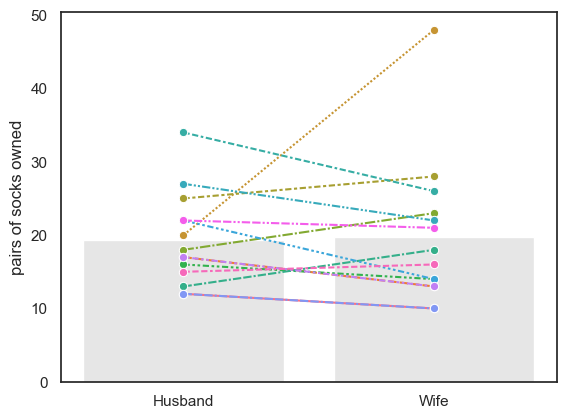

-0.42857142857142855


In [40]:
# Make a copy so we do not overwrite the original data
perm = pd.read_csv('https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook_2024/main/data/socks.csv')

# Loop over couples
for i in range(len(perm)):
    
    # Choose a random number between 0 - 1 and check if its less than .5 
    # True = swap, False = keep the same
    flip = np.random.rand() < 0.5
    
    if flip:
        # Swap husband and wife values for this couple
        h = perm.loc[i, 'Husband'] #Save the current value of husband socks
        w = perm.loc[i, 'Wife']    #Save the current value of wife socks 
        perm.loc[i, 'Husband'] = w # Swap the value with the other 
        perm.loc[i, 'Wife'] = h    # Swap the value with the other


#Plot the randomly sampled data
sns.barplot(data=perm, errorbar=None, color=[0.9,0.9,0.9])
sns.lineplot(data=perm.T, legend=False, marker='o') # ci=None switches off errorbars
plt.ylabel('pairs of socks owned')
plt.show()

# Compute the test statistic for THIS permutation
test_stat = (perm['Husband'] - perm['Wife']).mean()
print(test_stat)

## Run Many shuffles

To get a fine-grained estimate of how likely it is to get a test statistic of 4.6 due to chance, we need to run a *lot* of shuffles. We will use a double loop here where we loop through the number of repetitions, and then loop through the couples and randomly decide whether or not ro swap their labels. To start with let's repeat this process 100 times. We will then plot the test statistic from each of those permutations in a histogram below: 

<Axes: ylabel='Count'>

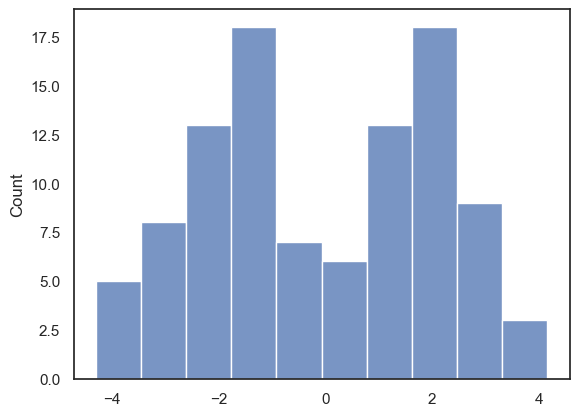

In [57]:
nReps = 100
perm_tests = np.empty(nReps)

for j in range(nReps):
    # Make a copy so we do not overwrite the original data
    perm = pd.read_csv('https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook_2024/main/data/socks.csv')
    
    # Loop over couples
    for i in range(len(perm)):
        
        # Choose a random number between 0 - 1 and check if its less than .5 
        # True = swap, False = keep the same
        flip = np.random.rand() < 0.5
        
        if flip:
            # Swap husband and wife values for this couple
            h = perm.loc[i, 'Husband'] #Save the current value of husband socks
            w = perm.loc[i, 'Wife']    #Save the current value of wife socks 
            perm.loc[i, 'Husband'] = w # Swap the value with the other 
            perm.loc[i, 'Wife'] = h    # Swap the value with the other
    
    perm_tests[j] = (perm['Husband'] - perm['Wife']).mean()



#Plot the randomly sampled data
sns.histplot(data=perm_tests, bins = 10)

With 100 permutations you can already begin to see that our test statistic of 4.6 occured quite infrequently in a case where there truly was no difference in the number of socks owned by husbands and wives. However, to increase our confidence we probably want to run even more permutations!

## Run 10000 shuffles

We can replace the "homebaked" version of our code above with an inbuilt function from the library `scipy.stats`, called `scipy.stats.permutation_test()`. This will have a few advantages. First, the inbuilt function is much faster and therefore we can easily increase the number of permutattions without costing too much time. The function also provides some additional output which we will take a closer look at below. Start by running the code block below - don't worry too much about the syntax we'll dive into that later...


In [68]:
def mDiff(x, y):
    return np.mean(x-y)

results = stats.permutation_test((socks.Husband, socks.Wife), mDiff, permutation_type='samples', alternative='greater', n_resamples=10000)

print(results)

PermutationTestResult(statistic=np.float64(4.571428571428571), pvalue=np.float64(0.0066993300669933005), null_distribution=array([-1.42857143,  0.71428571, -3.71428571, ..., -1.        ,
       -1.        ,  0.85714286], shape=(10000,)))


The results are displayed below the code box; there are number of outputs from the test (contained in the parentheses)

* **statistic** - the test statistic (mean difference) from our actual data, ie 4.6
* **pValue** - the proportion of shuffles in which a result greater than 4.6 was obtained (due to chance)
* **null distribution** - this contains all 10,000 mean-difference values, for the 10,000 shuffles

### The Null Distribution

The **null distribution** is the set of 10,000 values we get for mean difference (Husband-Wife), from our 10,000 shuffles. This is equivalent to the histogram plot we made above only with 100 times as much data!

Let's plot the null distribution in a histogram we will mark the test statistic from our actual data with a red dotted line:

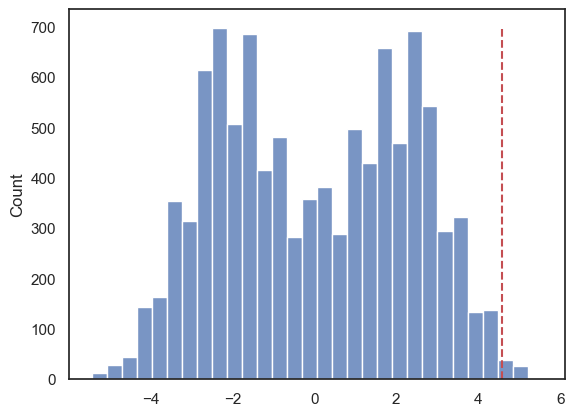

In [69]:
sns.histplot(results.null_distribution)
plt.plot([results.statistic,results.statistic],[0,700], 'r--')
plt.show()

We can see that indeed, only in a few cases did the mean difference exceed 4.6.

The distribution of differences of means from shuffled data looks pretty odd (with two peaks). This probably reflects the fact that whether the difference (Husbands-Wives) is positive or negative is strongly influenced by whether the hich-sock person (with 48 pairs of socks) happens to be labelled as a husband or a wife; one of the peaks in the null distribution will be shuffles where that person was labelled as male, and the other peak will be shuffles where they were labelled as female. We could see a similar pattern in our double loop version again, however there the shape of the data was not as pronounced.

### The $p$ value

We can calculate the exact proportion of cases in which the mean difference in socks owned for [Husband-Wife] exceeds the value we observed in our original sample, 4.6, as follows:

In [73]:
# check which values is the null distribution are greater than 4.6 and code as 1/0
# then use the numpy function np.mean() to get the avergae of those ones and zeros (ie he proportion of 1s)
print(np.mean(results.null_distribution >= 4.57))

0.0066


The proportion of shuffles in which the mean difference is greater than 4.6 is small! The exact value will vary every time you run this (because it is based on random permutations) but it should be less then 1% ( < .01). That means out of the 10000 shuffles we found a difference between husbands and wives of 4.57 or higher in fewer then 100 cases. You can confirm this with a final sanity check

In [75]:
print(sum(results.null_distribution >= 4.57))

66


#### Interpretation

If we simulate a situation in which sex does not determine the number of socks owned (but preserving some other important features of the dataset like the high skew, and the correlation between husabnds and their wives), there is less then 1% chance that we would get an apparent sex difference as large as the one we observed in our 'real' data.

The probability that the test statistic (in this case, the mean difference in pairs of socks owned) would be observed if the null hypothesis were true, is sometimes called the <b><i>$p$-value</i></b>. 

Our permutation test shows that the $p$-value associated with the observed difference of means is 0.66% or p=0.0066. (Remember: The exact values here will change slightly!)

The result is considered statistically significant if $p$ is smaller than some predetermined level, known as $\alpha$. Usually $\alpha = 0.05$ or $\alpha = 0.01$ is used, so the result is significant if $p<0.05$ or $p<0.01$. Our result is therefore statistically significant.

## Syntax of `stats.permutation_test()`

Let's have a look at the Python code to run the permutation test.

Firstly, we had to give the function `stats.permutation_test()` our two samples <tt>(socks.Husband, socks.Wife)</tt> as a pair of <b>series</b> (individual columns from the dataframe), rather than giving it the whole pandas dataframe as we do for many other stats functions.

Secondly, to tell `stats.permutation_test()` the test statistic we want to get the null distribution of, we had to pass it a *function* that calculates that test statistic. We created that function, `mDiff()`, using a function definition, before running the permutation test

### Arguments

When running the permutation test, we have to specify some arguments

* **n_resamples** the number of shuffles to do. (here 10000)
* **alternative** - whether to do a one-tailed test (and in whcih direction: 'greater' counts how many shuffles result in test statistic values greater than the one obtained from unshuffled data) or a two tailed test
* **permutation_type** - pairings, samples, or independent. These are for test of correlation, paired data and unpaired data respectively.

Here we are testing for a mean difference in paired data, so we choose `permutation_type='samples'`; the samples in this case are the men and women (husbands and wives) - we are permuting the data by moving people between samples (flipping husband/wife labels) but not moving people between couples.


## Recap

To run a permutation test on paired data, we randomly flipped some of the pairs so that the husband's sock count was assigned to the wife and vice versa. We did NOT move people between couples, as we want to retain the characteristic of the original dataset that high-sock husbands tend to have high-sock wives

For each shuffle we calculated the mean (pairwise) difference in the number of socks - husband-wife. 

Permutation testing in this way gives us a null distribution for the mean difference. Values of mean difference that occur rarely in the null distribution are considered statistically significant.
    
To run the permutation test with <tt>scipy.stats</tt> we need the option `permutation_type='samples'`